In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
import tensorflow as tf
import keras

In [21]:
# 读取文件
df  = pd.read_csv("./powerconsumption.csv")

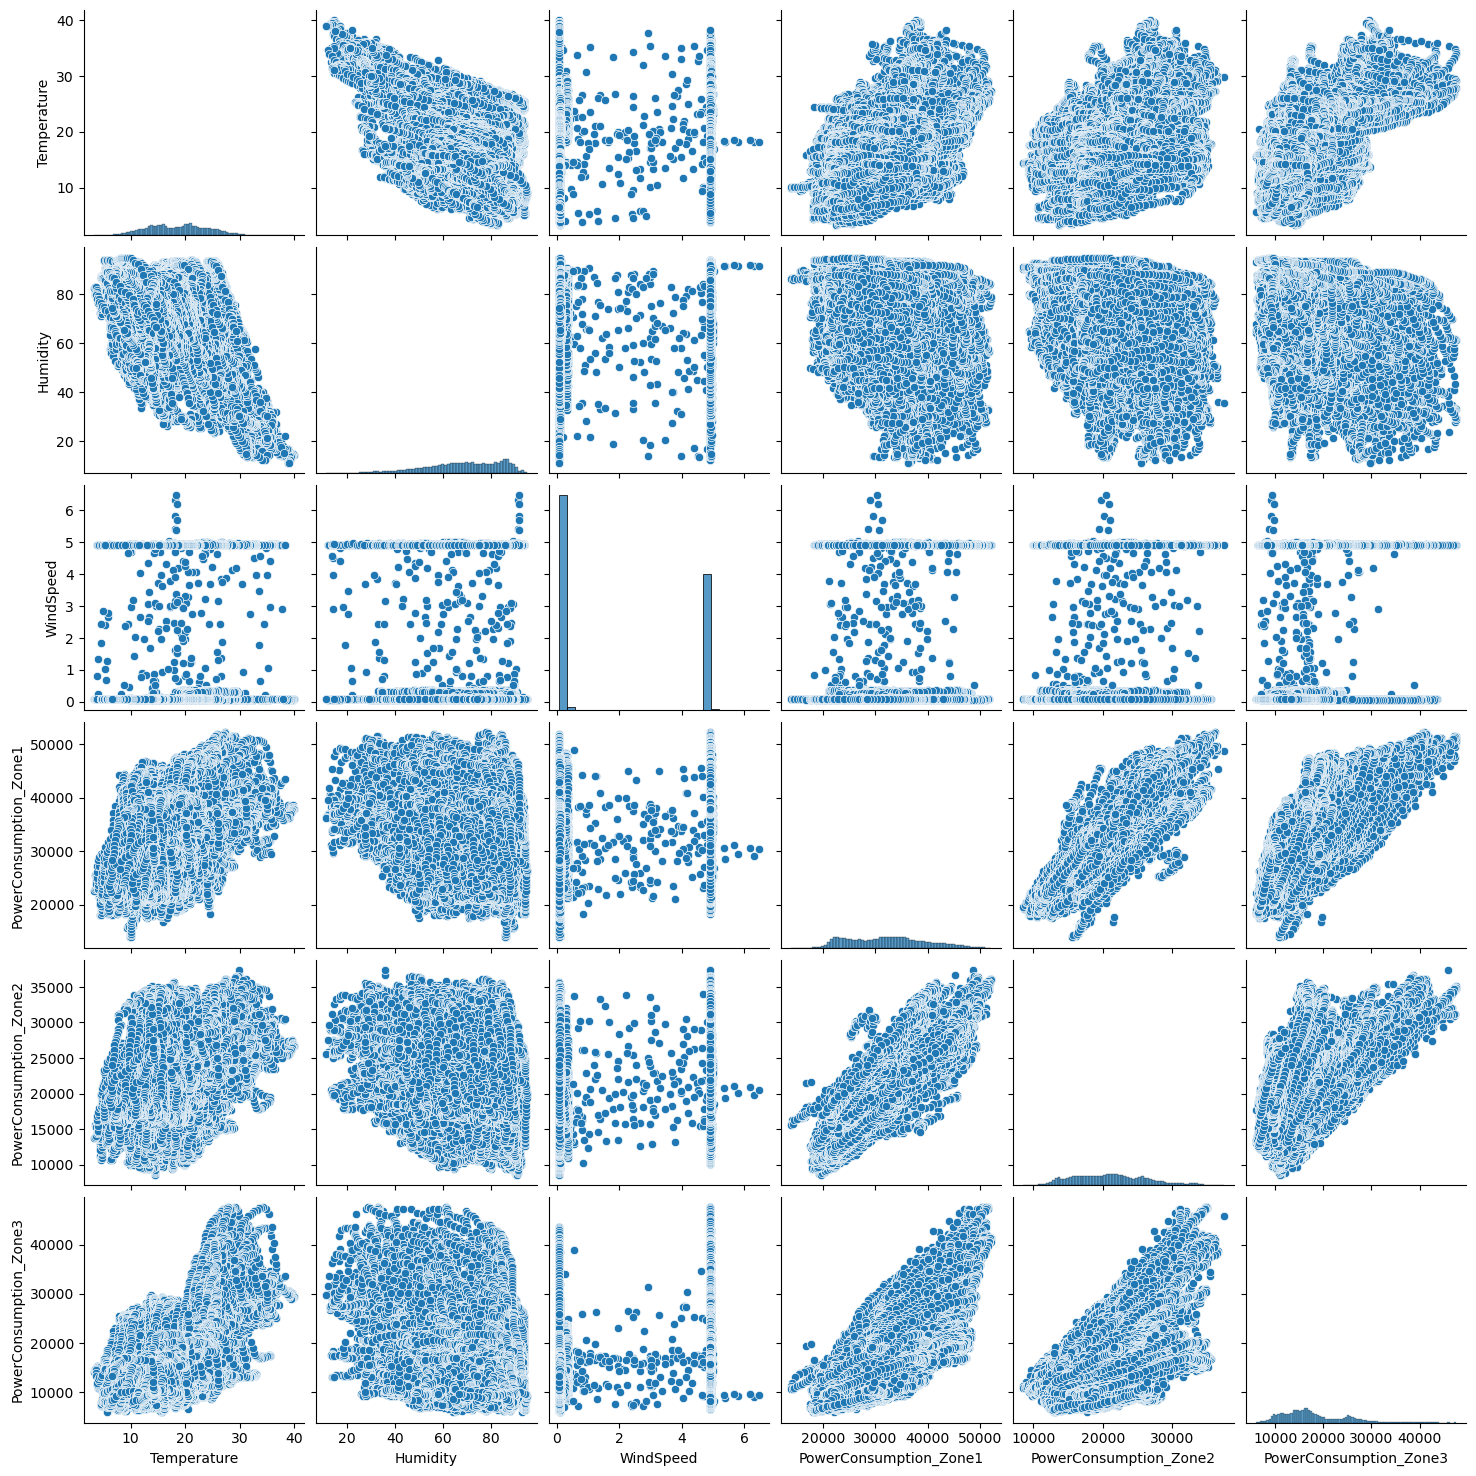

In [3]:
# 相关性可视化
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

In [ ]:
# 绘制区域1年度数据
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [ ]:
# 绘制区域2年度数据
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [ ]:
# 绘制区域3年度数据
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [22]:
#特征工程
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
    
    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)
    
    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']
    
    return df.astype(float)

In [23]:
#特征工程
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)
df = df.set_index('Datetime')
df = create_features(df)
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


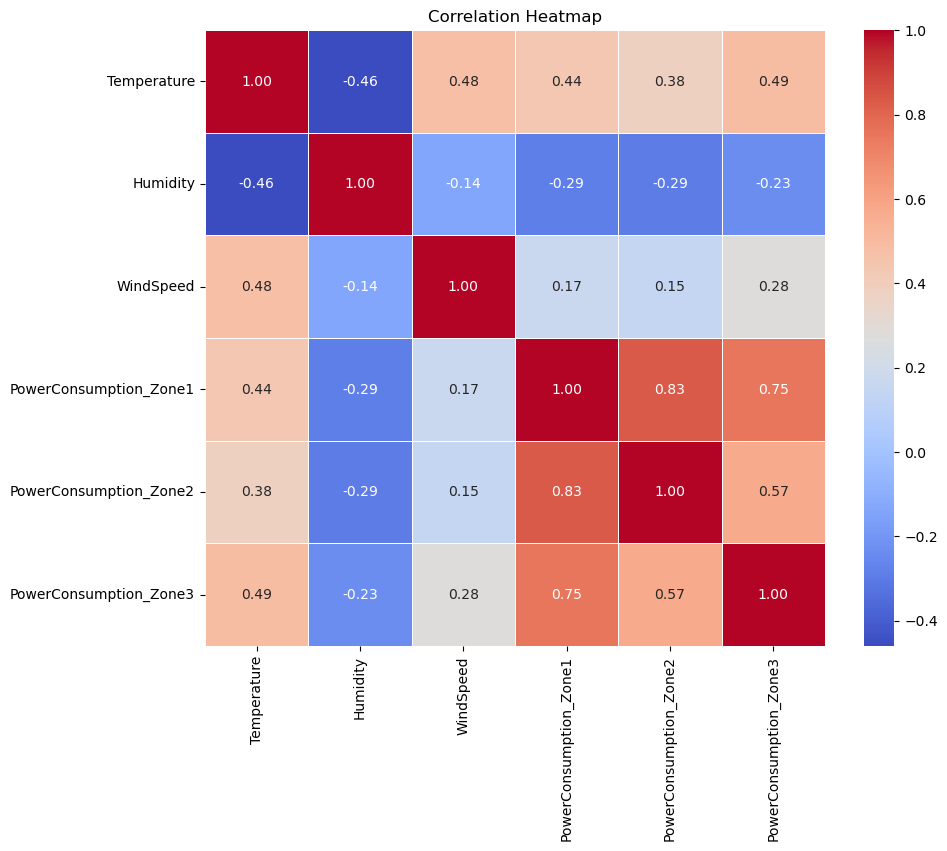

In [24]:
#相关矩阵
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

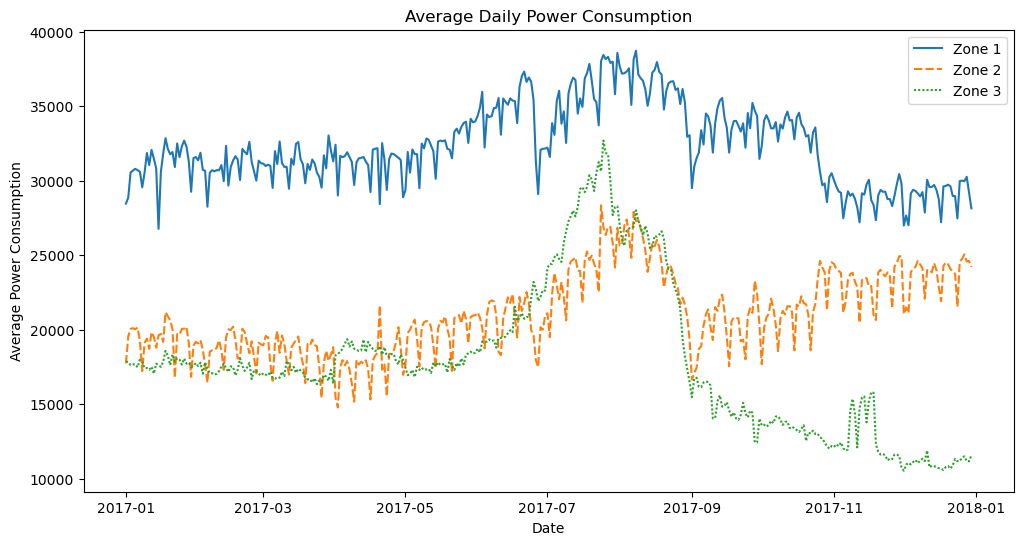

In [25]:
# 日平均用电量
daily_resampled = df.resample('D').mean()
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

In [26]:
# 归一化，分割训练集，数据集
from sklearn.preprocessing import StandardScaler

X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

In [29]:
# 模型训练参数
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [31]:
# 制作时间序列训练集
timestep = 6 * 24

X_train_LSTM = []
Y_train_LSTM = []
for end_timeslice in range(timestep, len(y_train)):
    X_train_LSTM.append(y_train[end_timeslice - timestep: end_timeslice])
    Y_train_LSTM.append(y_train[end_timeslice])

X_train_LSTM = np.array(X_train_LSTM)
Y_train_LSTM = np.array(Y_train_LSTM)

X_test_LSTM = []
Y_test_LSTM = []
for end_timeslice in range(timestep, len(y_test)):
    X_test_LSTM.append(y_test[end_timeslice - timestep: end_timeslice])
    Y_test_LSTM.append(y_test[end_timeslice])

X_test_LSTM = np.array(X_test_LSTM)
Y_test_LSTM = np.array(Y_test_LSTM)

In [32]:
# 定义时间序列分析模型
model_lstm_ts = Sequential()
model_lstm_ts.add(LSTM(50, activation='relu', input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model_lstm_ts.add(Dense(3))
model_lstm_ts.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(0.000003))
model_lstm_ts.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 10953 (42.79 KB)
Trainable params: 10953 (42.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# 训练模型
lstm_history = model_lstm_ts.fit(X_train_LSTM, Y_train_LSTM, epochs=30, verbose=1)

Epoch 1/30
1224/1224 [==============================] - 29s 24ms/step - loss: 0.2665
Epoch 2/30
1224/1224 [==============================] - 30s 24ms/step - loss: 0.2533
Epoch 3/30
1224/1224 [==============================] - 31s 25ms/step - loss: 0.2384
Epoch 4/30
1224/1224 [==============================] - 32s 26ms/step - loss: 0.2222
Epoch 5/30
1224/1224 [==============================] - 32s 26ms/step - loss: 0.2049
Epoch 6/30
1224/1224 [==============================] - 33s 27ms/step - loss: 0.1862
Epoch 7/30
1224/1224 [==============================] - 33s 27ms/step - loss: 0.1669
Epoch 8/30
1224/1224 [==============================] - 32s 26ms/step - loss: 1569.6588
Epoch 9/30
1224/1224 [==============================] - 33s 27ms/step - loss: 0.1529
Epoch 10/30
1224/1224 [==============================] - 33s 27ms/step - loss: 0.1511
Epoch 11/30
1224/1224 [==============================] - 33s 27ms/step - loss: 0.1495
Epoch 12/30
1224/1224 [==============================] - 32s

In [40]:
# 多曲线绘制函数
%matplotlib inline

def plot_curve(data_list, labels, title, xlabel, ylabel):
    time_points = np.arange(len(data_list))
    curves = []
    # 获取值
    for i in range(len(data_list[0])):
        curves.append(data_list[:, i])
    # 创建图形对象
    fig, ax = plt.subplots()
    # 绘制折线图
    for i in range(len(data_list[0])):
        ax.plot(time_points, curves[i], label=labels[i])
    # 添加图例
    ax.legend()
    # 设置X轴和Y轴标签
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # 设置图形标题
    ax.set_title(title)
    fig.show()

In [41]:
# 预测
test_predict_ts = model_lstm_ts.predict(X_test_LSTM)
reformed = scaler_y.inverse_transform(test_predict_ts)
reformed_valid = scaler_y.inverse_transform(Y_test_LSTM)

405/405 [==============================] - 5s 12ms/step


In [43]:
# 计算预测偏差
mse = mean_squared_error(Y_test_LSTM , test_predict_ts)
mae = mean_absolute_error(Y_test_LSTM , test_predict_ts)

print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

Mean squared error on test set: 0.4055
Mean absolute error on test set: 0.5204


C:\Users\ERQI\AppData\Local\Temp\ipykernel_57904\865626313.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


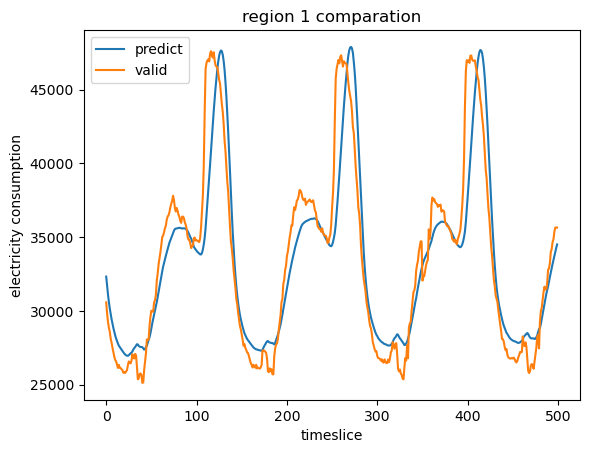

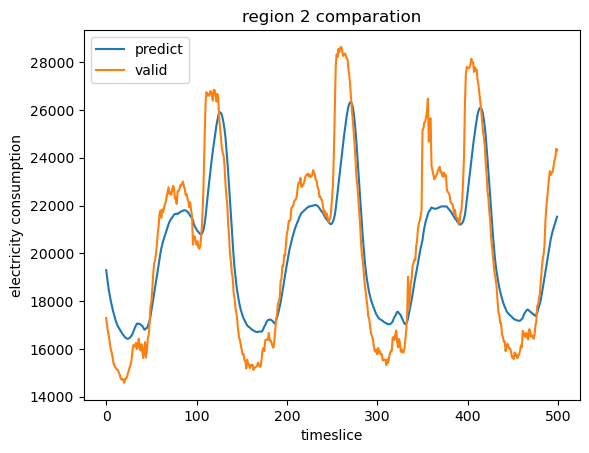

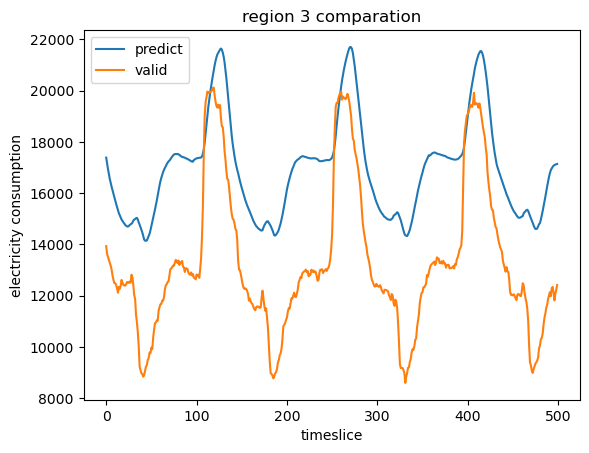

In [44]:
# 绘制对比曲线
show_start = 0
show_len = 500
for i in range(3):
    compare = np.column_stack((reformed[show_start:show_start + show_len][:, i], reformed_valid[show_start:show_start + show_len][:, i]))
    plot_curve(compare, ["predict", "valid"], "region " + str(i + 1) + " comparation", "timeslice", "electricity consumption")

In [46]:
# 制作训练样本
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [47]:
# 回归预测模型

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10553 (41.22 KB)
Trainable params: 10553 (41.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# 训练
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=20, verbose=1)

Epoch 1/20
1229/1229 [==============================] - 9s 7ms/step - loss: 2429.2610 - val_loss: 28.7970
Epoch 2/20
1229/1229 [==============================] - 8s 6ms/step - loss: 18.9044 - val_loss: 41.6289
Epoch 3/20
1229/1229 [==============================] - 8s 6ms/step - loss: 13.0876 - val_loss: 19.6030
Epoch 4/20
1229/1229 [==============================] - 8s 6ms/step - loss: 4.1421 - val_loss: 5.2141
Epoch 5/20
1229/1229 [==============================] - 8s 6ms/step - loss: 1.8396 - val_loss: 2.6908
Epoch 6/20
1229/1229 [==============================] - 8s 6ms/step - loss: 1.1208 - val_loss: 1.8145
Epoch 7/20
1229/1229 [==============================] - 8s 7ms/step - loss: 0.8479 - val_loss: 1.4129
Epoch 8/20
1229/1229 [==============================] - 8s 7ms/step - loss: 0.8252 - val_loss: 1.5409
Epoch 9/20
1229/1229 [==============================] - 10s 8ms/step - loss: 0.8703 - val_loss: 1.3478
Epoch 10/20
1229/1229 [==============================] - 9s 7ms/step - lo

In [49]:
# 预测
test_predict_recur = model_lstm.predict(X_test)

410/410 [==============================] - 1s 2ms/step


In [50]:
# 还原数据
reformed = scaler_y.inverse_transform(test_predict_recur)
reformed_valid = scaler_y.inverse_transform(y_test)

C:\Users\ERQI\AppData\Local\Temp\ipykernel_57904\865626313.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


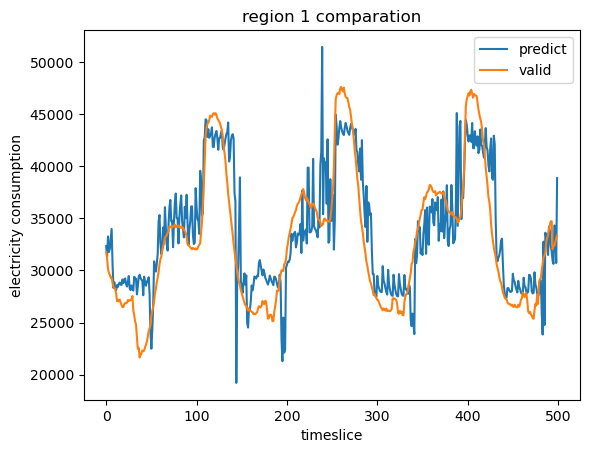

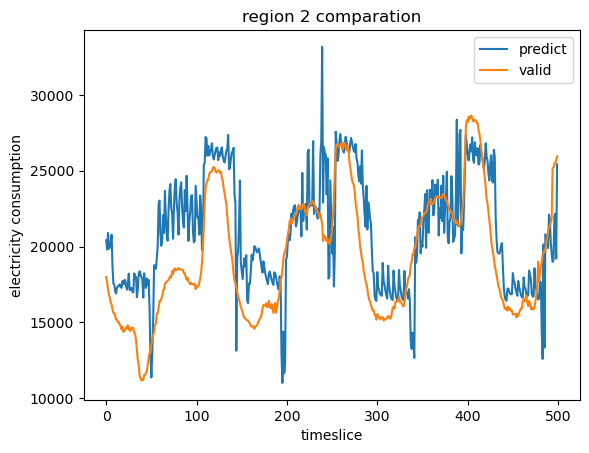

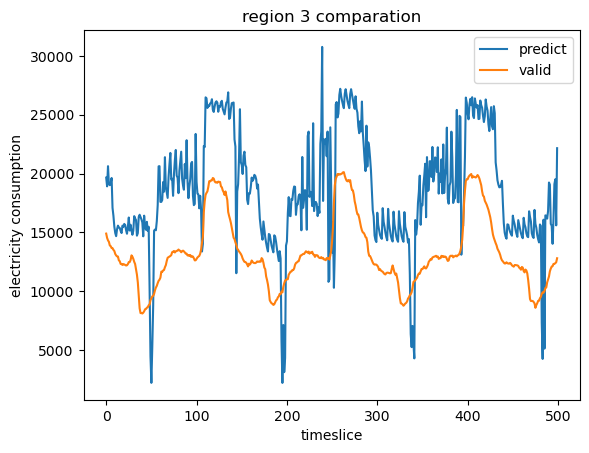

In [51]:
# 绘制预测和实际曲线
show_len = 500
for i in range(3):
    compare = np.column_stack((reformed[:show_len][:, i], reformed_valid[:show_len][:, i]))
    plot_curve(compare, ["predict", "valid"], "region " + str(i + 1) + " comparation", "timeslice", "electricity consumption")

In [53]:
# 计算偏差值
mse = mean_squared_error(y_test, test_predict_recur)
mae = mean_absolute_error(y_test, test_predict_recur)

print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

Mean squared error on test set: 1.0936
Mean absolute error on test set: 0.8579
